# 04 | Comparison with CFD

In this tutorial, we compare a CFD simulation against the centrifugal fan curve.

At this time, we assume, that previous notebooks have been viewed by the reader, hence not every of the following lines are explained in detail.


**First** Download the HDF5 files from here: https://zenodo.org/records/18378514

In [1]:
from opencefadb import OpenCeFaDB
from opencefadb.models.fan_curve import SemanticFanCurve

from opencefadb import plotting
import matplotlib.pyplot as plt

In [2]:
WORKING_DIR = "local-db"

In [3]:
USE_GRAPH_DB = True

if USE_GRAPH_DB:
    db = OpenCeFaDB.from_graphdb_setup(
        working_directory=WORKING_DIR,
        version="latest",
        endpoint="http://localhost:7200",
        repository="OpenCeFaDB",
        username="admin",
        password="admin",
        add_wikidata_store=False
    )
else:
    db = OpenCeFaDB.from_rdflib_setup(
        working_directory=WORKING_DIR,
        version="latest",
    )

 [OpenCeFa DB]: Searching for the latest version...
 [OpenCeFa DB]: downloading version 1.0.0...
 [OpenCeFa DB]: Downloaded latest OpenCeFaDB config file to 'local-db\opencefadb-catalog-1-0-0.ttl'.
 [OpenCeFa DB]: Validating downloaded catalog against SHACL shapes...
 [OpenCeFa DB]: Catalog is valid.


In [4]:
base = "https://doi.org/10.5281/zenodo.17572275#standard_name_table/"

sn_mean_nrot = base + "derived_standard_name/arithmetic_mean_of_fan_rotational_speed"
sn_mean_dp_stat = base + "derived_standard_name/arithmetic_mean_of_difference_of_static_pressure_between_fan_outlet_and_fan_inlet"
sn_mean_dp_tot = base + "derived_standard_name/arithmetic_mean_of_difference_of_total_pressure_between_fan_outlet_and_fan_inlet"
sn_mean_vfr = base + "derived_standard_name/arithmetic_mean_of_fan_volume_flow_rate"
sn_mean_rho = base + "derived_standard_name/arithmetic_mean_of_air_density"

## Reading in the simulation data

First we need to review the simulation data. It is available as HDF5 file. We will extract the data based on the standard names and then construct observation objects from it

In [5]:
import h5rdmtoolbox as h5tbx
import pathlib
import xarray as xr
from ontolutils.ex.sosa import Observation, Result
from ssnolib.m4i import NumericalVariable
from ssnolib.ssno import StandardName
from ontolutils.namespacelib import QUDT_KIND, QUDT_UNIT

In [6]:
simulation_filenames = sorted(pathlib.Path("cfd_sample_data/").glob("*.hdf"))

In [7]:
plain_sn_dptot_enregy_av = "difference_of_energy_averaged_total_pressure_and_energy_averaged_total_pressure_between_fan_outlet_and_fan_inlet"
plain_sn_dptot = "difference_of_total_pressure_and_total_pressure_between_fan_outlet_and_fan_inlet"
plain_sn_vfr = "fan_volume_flow_rate"

In [22]:
# helper function to extract the data:
def get_sim_operation_point_data(filename):
    
    with h5tbx.File(filename) as h5:
        ds_dptot_eng_av = h5.monitor["USER POINT"].find({"standard_name": plain_sn_dptot_enregy_av})[0]
        dptot_eng_av = ds_dptot_eng_av[-5000:]
        ds_vfr = h5.monitor["USER POINT"].find({"standard_name": plain_sn_vfr})[0]
        vfr = ds_vfr[-5000:]
        ds_dptot = h5.monitor["USER POINT"].find({"standard_name": plain_sn_dptot})[0]
        dptot = ds_dptot[-5000:]


    with xr.set_options(keep_attrs=True):
        vfr_mean = vfr.mean()
        vfr_mean.attrs["standard_name"] = f"arithmetic_mean_of{vfr.standard_name}"
        
        dptot_eng_av_mean = dptot_eng_av.mean()
        dptot_eng_av_mean.attrs["standard_name"] = f"arithmetic_mean_of_{dptot_eng_av.standard_name}"
        
        dptot_mean = dptot.mean()
        dptot_mean.attrs["standard_name"] = f"arithmetic_mean_of_{dptot.standard_name}"

    vfr_mean_res = Result(
        has_numerical_variable=NumericalVariable(
            label="Volumenstrom",
            has_standard_name=sn_mean_vfr,
            hasNumericalValue=vfr_mean.data,
            hasUnit=QUDT_UNIT.M3_PER_SEC,
            hasKindOfQuantity=QUDT_KIND.RotationalVelocity
        )
    )
    dptot_eng_av_res = Result(
        has_numerical_variable=NumericalVariable(
            label="Totaldruckdifferenz (energetisch gemittelt)",
            has_standard_name=base + f'derived/arithmetic_mean_of_{dptot_eng_av.standard_name}',
            hasNumericalValue=dptot_eng_av_mean.data,
            hasUnit=QUDT_UNIT.PA,
            hasKindOfQuantity=QUDT_KIND.TotalPressure
        )
    )
    dptot_mean_res = Result(
        has_numerical_variable=NumericalVariable(
            label="Totaldruckdifferenz",
            has_standard_name=sn_mean_dp_tot,
            hasNumericalValue=dptot_mean.data,
            hasUnit=QUDT_UNIT.PA,
            hasKindOfQuantity=QUDT_KIND.TotalPressure
        )
    )
    n_rot = Result(
        has_numerical_variable=NumericalVariable(
            label="Drehzahl",
            has_standard_name=sn_mean_nrot,
            hasNumericalValue=1000,
            hasUnit=QUDT_UNIT.REV_PER_MIN,
            hasKindOfQuantity=QUDT_KIND.RotationalVelocity
        )
    )
    return Observation(
        has_result=[vfr_mean_res, dptot_eng_av_res, dptot_mean_res, n_rot]
    )

### Construct the simulation fan curve

Just as with experimental data, we can create the `SemanticFanCurve` object:

In [23]:
sim_observations = [get_sim_operation_point_data(f) for f in simulation_filenames]
fan_curve_sim = SemanticFanCurve.from_observations(observations=sim_observations)

### Plot the simulation curve

Note, that we will investigate here also the difference it makes to use the energy averaged total pressure difference versus the total pressure difference computed as the experiment does (from the wall pressure):

 [OpenCeFa DB]: Obtaining plotting data...
 [OpenCeFa DB]: ... done.
 [OpenCeFa DB]: Obtaining plotting data...
 [OpenCeFa DB]: ... done.


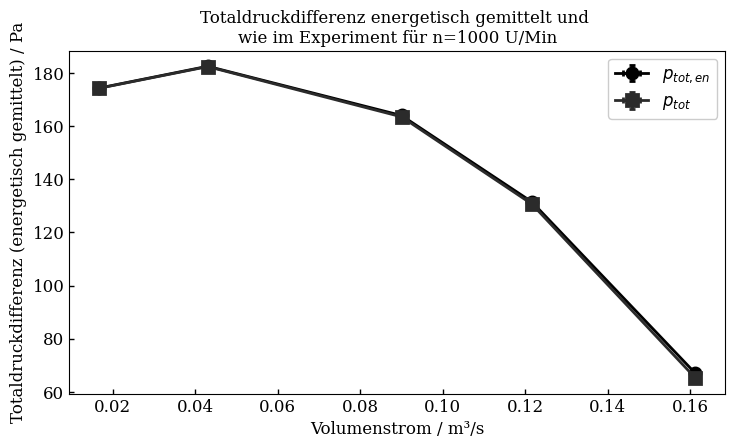

In [24]:
with plotting.SingleAxis(
        scale=1.2,
        filename=None,
) as dax:
    _n = fan_curve_sim.get_result_by_standard_name(iri=sn_mean_nrot)[0].hasNumericalVariable.hasNumericalValue
    fan_curve_sim.errorbar(
        x=sn_mean_vfr,
        y=sn_mean_dp_tot,
        xlabel=None,
        ylabel=None,
        label=f"$p_{{tot,en}}$",
        marker="o",
        markersize=8,
        linestyle='-',
        ax=dax.ax,
        raise_on_no_data_points=False,
        verbose=True
    )
    fan_curve_sim.errorbar(
        x=sn_mean_vfr,
        y="https://doi.org/10.5281/zenodo.17572275#standard_name_table/derived/arithmetic_mean_of_difference_of_energy_averaged_total_pressure_and_energy_averaged_total_pressure_between_fan_outlet_and_fan_inlet",
        xlabel=None,
        ylabel=None,
        label=f"$p_{{tot}}$",
        marker="s",
        markersize=8,
        linestyle='-',
        ax=dax.ax,
        raise_on_no_data_points=False,
        verbose=True
    )
    plt.title("Totaldruckdifferenz energetisch gemittelt und \nwie im Experiment für n=1000 U/Min")
    plt.legend()
    plt.tight_layout()

## Compare with experiment

Now, let's query the experimental data:

In [25]:
operating_point_standard_names = {
    sn_mean_dp_stat,
    sn_mean_dp_tot,
    sn_mean_vfr,
    sn_mean_nrot,
    sn_mean_rho
}


observations = db.get_operating_point_observations(
    n_rot_speed_rpm=1000,
    operating_point_standard_names=operating_point_standard_names,
    standard_name_of_rotational_speed=sn_mean_nrot,
    n_rot_tolerance=0.05 # 5 %
)

def get_scale_n_rot(n_rpm):
    return NumericalVariable(
            has_numerical_value=n_rpm,
            has_unit=QUDT_UNIT.REV_PER_MIN,
            has_kind_of_quantity=QUDT_KIND.RotationalVelocity,
            has_standard_name=sn_mean_nrot
        )

Processing operating point datasets: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.38 datasets/s]


In [26]:
fan_curve = SemanticFanCurve.from_observations(observations=observations)

fan_curve_scaled = fan_curve.scale(get_scale_n_rot(1000))

 [OpenCeFa DB]: Obtaining plotting data...
 [OpenCeFa DB]: ... done.
 [OpenCeFa DB]: Obtaining plotting data...
 [OpenCeFa DB]: ... done.


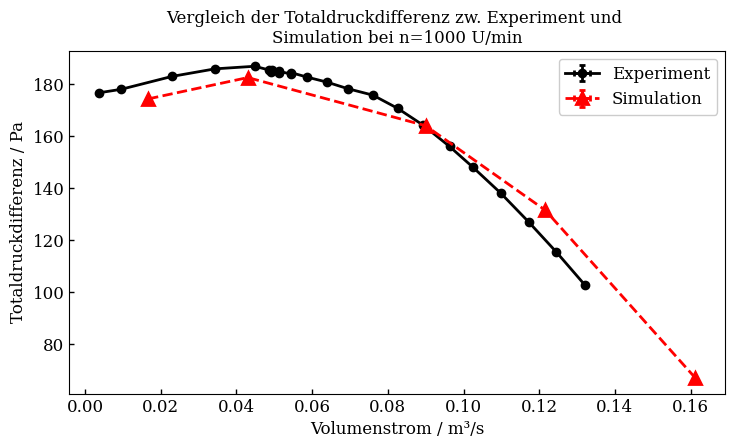

In [27]:
with plotting.SingleAxis(
        scale=1.2,
        filename=None,
) as dax:
    _n = fan_curve_scaled.get_result_by_standard_name(iri=sn_mean_nrot)[0].hasNumericalVariable.hasNumericalValue
    fan_curve_scaled.errorbar(
        x="arithmetic_mean_of_fan_volume_flow_rate",
        y="arithmetic_mean_of_difference_of_total_pressure_between_fan_outlet_and_fan_inlet",
        xlabel=None,
        ylabel=None,
        label="Experiment",
        marker=".",
        linestyle='-',
        ax=dax.ax,
        raise_on_no_data_points=False,
        verbose=True
    )
    _n_sim = fan_curve_sim.get_result_by_standard_name(iri=sn_mean_nrot)[0].hasNumericalVariable.hasNumericalValue
    fan_curve_sim.errorbar(
        x=sn_mean_vfr,
        y=sn_mean_dp_tot,
        xlabel=None,
        ylabel=None,
        label="Simulation",
        marker="^",
        markersize=8,
        color="r",
        linestyle="--",
        ax=dax.ax,
        raise_on_no_data_points=False,
        verbose=True
    )
    plt.title("Vergleich der Totaldruckdifferenz zw. Experiment und \nSimulation bei n=1000 U/min")
    plt.legend()
    plt.tight_layout()